In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm

import choropleth_pipeline as cp

### Geometriedaten laden

In [2]:
# pfad für geometrie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# Geometriedaten
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")  # id_col hier nur informativ; wir joinen manuell

gemeinden = cp.load_level(vg, 'GEM')
kreise = cp.load_level(vg, 'KRS')
laender = cp.load_level(vg, 'LAN')

# Für Kreise sind die drei letzten Stellen null!
kreise['AGS8'] = kreise['ARS'].str[:5]+"000"

### Bevölkerungsanteil über 65

In [3]:
u65 = pd.read_csv(
    'csv/U65_kreise.csv',
    usecols = ['KRS1222','Kreisname','bev_ue65'],
    dtype={'KRS1222':'string','bev_ue65':'float'}
)

In [4]:
gdf = kreise.merge(
    u65,
    left_on  = 'AGS8',
    right_on = 'KRS1222',
    how = 'inner'
)

gdf['bev_ue65_z'] = cp.robust_z(gdf['bev_ue65'])
gdf['bev_ue65_z_0_100'] = cp.scale_0_100(gdf['bev_ue65_z'])

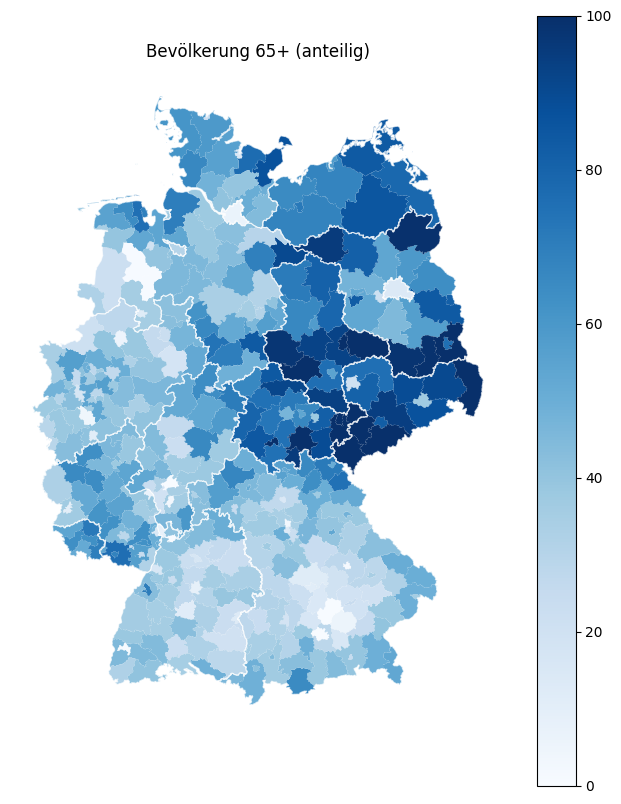

In [5]:
fig, ax = cp.plot_choropleth_continuous(
    gdf,
    value_col=f"bev_ue65_z_0_100",
    cmap_name="Blues",          
    title=f"Bevölkerung 65+ (anteilig)",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100) 
)

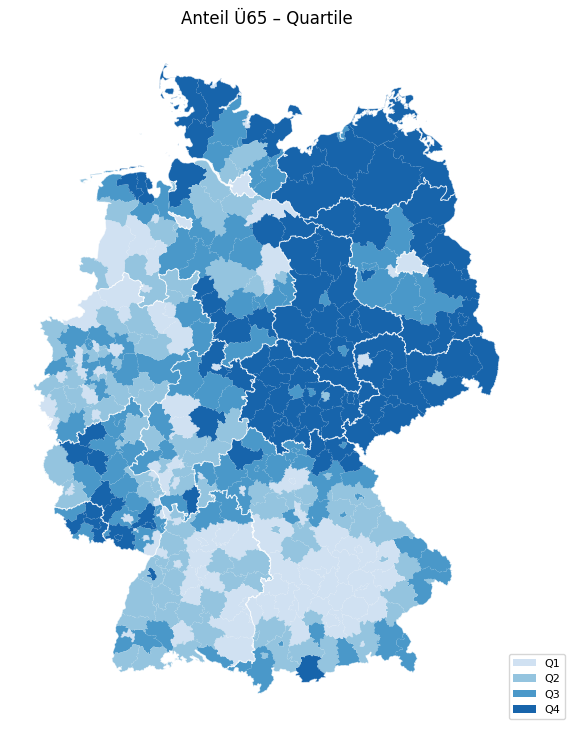

In [6]:
col = "bev_ue65_z_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]


colors = cp.colors_from_mpl("Blues", len(labels), clip = 0.2) 

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Anteil Ü65 – Quartile",
    # legend_offset_cm=1.0
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"U65_zscaled_Qs.png", 
    out_dir="exports/Zusatzkarten",
    dpi=300
)


### Hotspost - oberstes Dezil (90%)

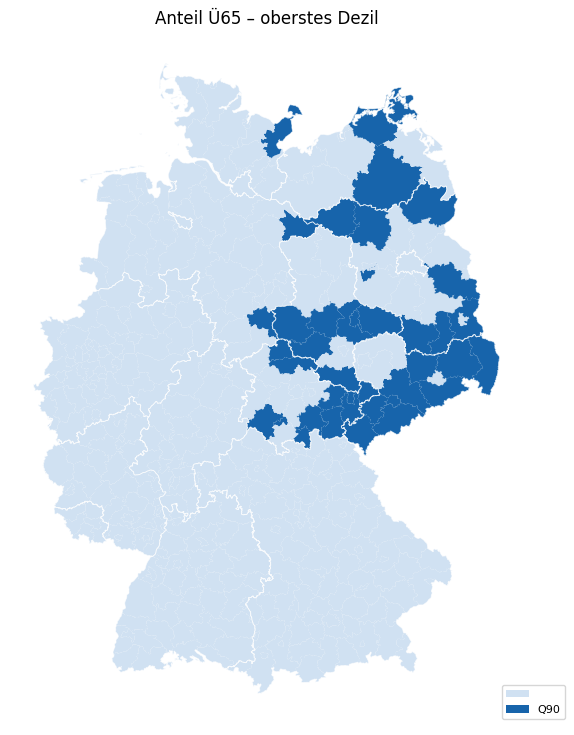

In [7]:
col = "bev_ue65_z_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0,.9, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 3:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 3)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = [f"", 'Q90'][:bins.size - 1]

# labels = [
#     f"Q1: ≤ {qs[1]:.1f}",
#     f"Q2: {qs[1]:.1f} – {qs[2]:.1f}",
#     f"Q3: {qs[2]:.1f} – {qs[3]:.1f}",
#     f"> {qs[3]:.1f}",
# ]

colors = cp.colors_from_mpl("Blues", len(labels), clip = 0.2) 

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Anteil Ü65 – oberstes Dezil",
    # legend_offset_cm=1.0
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"U65_zscaled_90.png", 
    out_dir="exports/Zusatzkarten",
    dpi=300
)


### Flächennutzung

In [8]:
flaechen = pd.read_csv(
    'csv/U65_kreise.csv',
    usecols = ['KRS1222','Kreisname','fl_suv', 'fl_landw', 'fl_wald'],
    dtype={'KRS1222':'string'}
)

In [9]:

flaechen['fl_wald_und_landw'] = flaechen['fl_wald'] + flaechen['fl_landw']

cols = ['fl_suv', 'fl_landw', 'fl_wald', 'fl_wald_und_landw']

for col in cols:
    flaechen[col+'_z'] = cp.robust_z(flaechen[col])
    flaechen[col+'_z_0_100'] = cp.scale_0_100(flaechen[col])

gdf = kreise.merge(
    flaechen,
    left_on  = 'AGS8',
    right_on = 'KRS1222',
    how = 'inner'
)

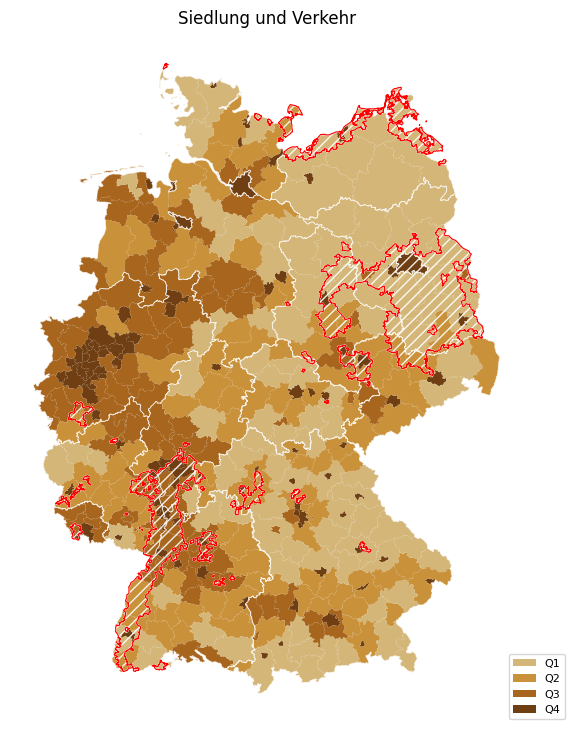

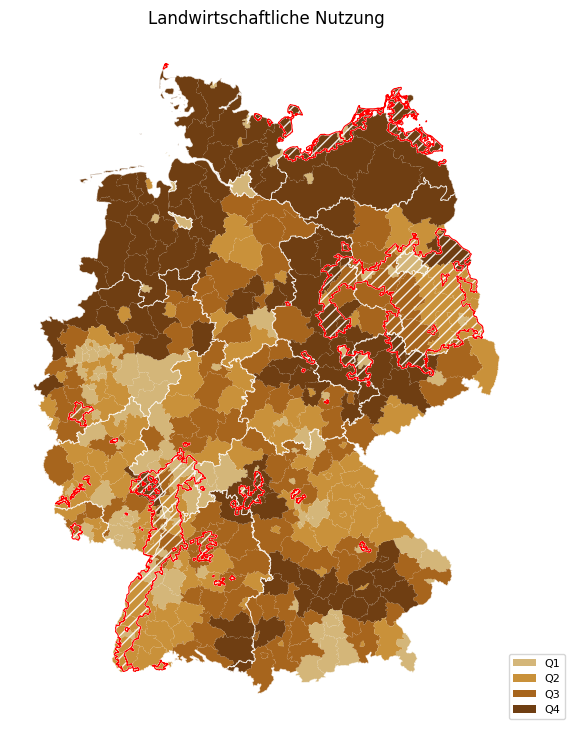

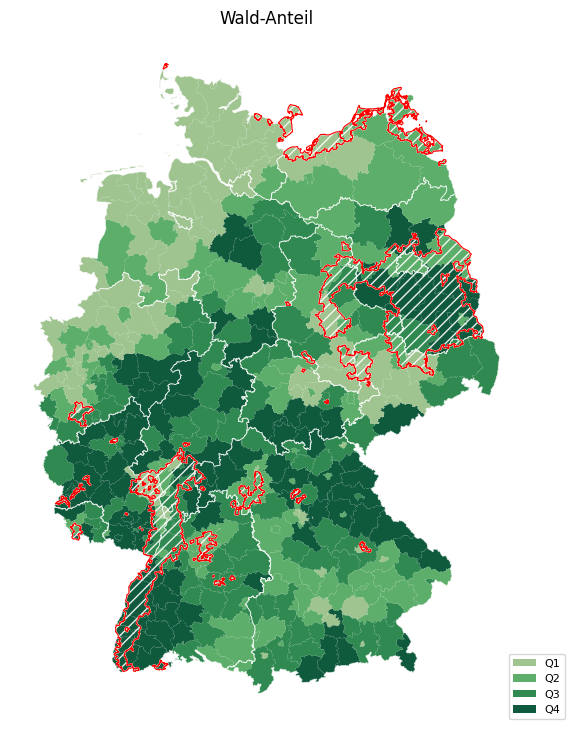

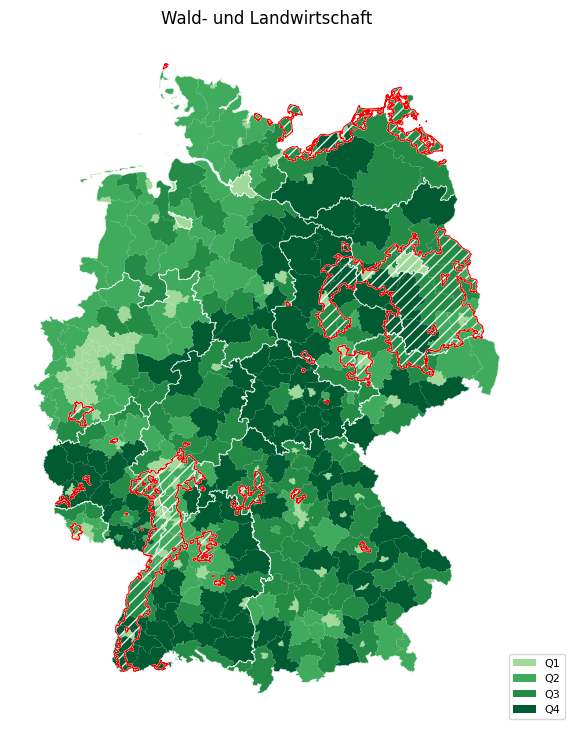

In [10]:
palettes = {
    'forest_1' : ["#9FC490", "#5DAE6A", "#2F8950", "#0F5A3D"],
    'forest_2' : ["#A1D99B", "#41AB5D", "#238B45", "#005A32"],
    'suv'      : ["#D4B679", "#C9913A", "#A7651D", "#6F3E12"],
    'agri'     : ["#C9DA5B", "#9BC53D", "#6BA539", "#3F7729"],
}

cols = ['fl_suv_z_0_100', 'fl_landw_z_0_100', 'fl_wald_z_0_100','fl_wald_und_landw_z_0_100']

titles = {
    'fl_suv_z_0_100':'Siedlung und Verkehr',
    'fl_landw_z_0_100':'Landwirtschaftliche Nutzung',
    'fl_wald_z_0_100':'Wald-Anteil',
    'fl_wald_und_landw_z_0_100':'Wald- und Landwirtschaft',
}

colormaps = {
    'fl_suv_z_0_100':'suv',
    'fl_landw_z_0_100':'suv',
    'fl_wald_z_0_100':'forest_1',
    'fl_wald_und_landw_z_0_100':'forest_2'
}

for col in cols:
    # Quartilschwellen (0, 25, 50, 75, 100 %)
    qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()
    
    # Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
    bins = np.unique(qs)
    if bins.size < 5:
        mn = float(np.nanmin(gdf[col]))
        mx = float(np.nanmax(gdf[col]))
        eps = np.nextafter(mx, np.inf) - mx
        bins = np.linspace(mn, mx + eps, 5)
    
    # letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
    bins[-1] = np.nextafter(bins[-1], np.inf)
    
    labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]
    
    # colors = cp.colors_from_mpl(cmaps[col], len(labels), clip = 0.2) 
    colors = palettes[colormaps[col]]
    
    fig, ax = cp.plot_choropleth_discrete(
        gdf, col,
        bins=bins, labels=labels, colors=colors,
        laender=laender,
        title=titles[col],
        # legend_offset_cm=1.0
    )

    #--------------------------------------------------------------------------
    # overlay q10 KEI Kontur
    # 90% Quantil-Schwelle berechnen
    
    gdf_hot = gpd.read_parquet('csv/q90.parquet').to_crs(laender.crs)
    
    gdf_hot.boundary.plot(
        ax = ax,
        # facecolor = 'white',
        color = 'white',
        hatch = '///',
        linewidth = 1.2,
        alpha = 0.9,
    )
    gdf_hot.boundary.plot(
        ax = ax,
        color = 'red',
        linewidth = 0.8,
    )
# ---------------------------------------------------------------------------

    
    # Speichern
    out_file = cp.save_map(
        fig, 
        filename=f"{titles[col]}_z_scaled_Qs_with_overlay.png", 
        out_dir="exports/Zusatzkarten",
        dpi=300
    )


# Urbanität

Urbanität $U$ setzt sich aus dem Siedlungs- und Verkehrsflächenanteil (SVF) sowie der Populationsdichte $\rho$ zusammen:
$$
U:=0.6\ z(\rho)^+ +0.4\ z(SVF)^+
$$

Wir definieren das untere Quartil als ländlich, Q2-Q3 als Übergang und Q4 als städtisch

In [11]:
# Bevölkerungsdichte auf Gemeinde-Niveau
population = pd.read_csv(
    'csv/Bevoelkerungsdichte_gemeinde_AGS.csv',
    usecols = ['AGS','bev_dicht'],
    dtype={'AGS':'string'}
)

flaechen = pd.read_csv(
    'csv/U65_kreise.csv',
        usecols = ['KRS1222','Kreisname','fl_suv', 'fl_landw', 'fl_wald', 'hh_veink'],
    dtype={'KRS1222':'string'}
)

flaechen['ARS5'] = flaechen['KRS1222'].str[:5]


In [12]:
# pfad für geometrie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# Geometriedaten
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")  # id_col hier nur informativ; wir joinen manuell

gemeinden = cp.load_level(vg, 'GEM')
kreise = cp.load_level(vg, 'KRS')
laender = cp.load_level(vg, 'LAN')

# Für Kreise sind die drei letzten Stellen null!
# Join für flächendaten auf Kreisebene
gemeinden['AGS8'] = gemeinden['ARS'].str[:5]+"000"


In [13]:
# Geometrie mit Daten mergen
gdf = gemeinden.merge(
    flaechen,
    left_on  = 'AGS8',
    right_on = 'KRS1222',
    how = 'inner'
).merge(
    population,
    left_on = 'AGS',
    right_on = 'AGS',
    how = 'inner'
)

In [14]:
gdf.shape

(10954, 35)

### Urbanität klassifizieren

In [15]:
cols = ['fl_suv', 'bev_dicht']

for col in cols:
    gdf[col+'_z'] = cp.robust_z(gdf[col])
    

In [16]:
gdf['fl_suv_z'].apply(lambda x: max(0,x))
gdf['bev_dicht_z'].apply(lambda x: max(0,x))

gdf['urbanity'] = 0.6 * gdf['bev_dicht_z'] + 0.4 * gdf['fl_suv_z']
gdf['urbanity_0_100'] = cp.scale_0_100(gdf['urbanity'])

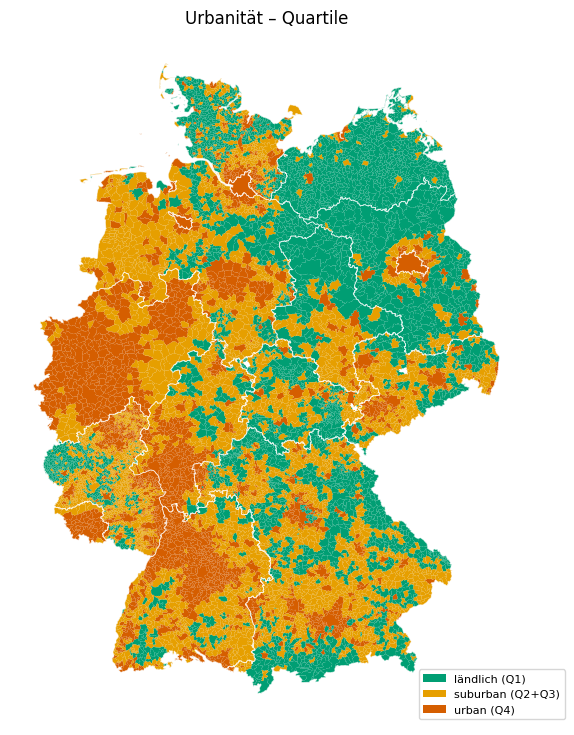

In [17]:
col = "urbanity_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 4)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["ländlich (Q1)", "suburban (Q2+Q3)", "urban (Q4)"][:bins.size - 1]

# colors = cp.colors_from_mpl("BrBG", len(labels), clip = 0.8) 
# colors = ['#2F7F64', '#F2C14E', '#B45309']
colors = ['#009E73', '#E69F00', '#D55E00']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Urbanität – Quartile",
    # legend_offset_cm=1.0
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Urbanity_index_Qs.png", 
    out_dir="exports/Zusatzkarten",
    dpi=300
)


### Deutschland ohne Werte

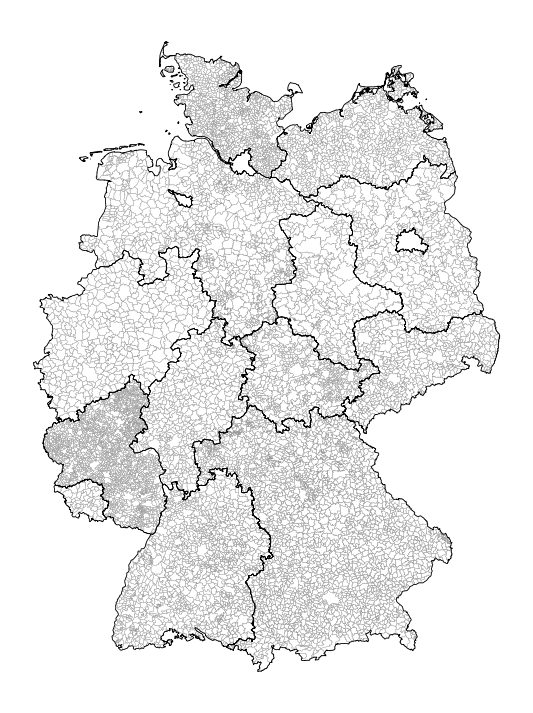

In [18]:
fig, ax = plt.subplots(figsize=(8,9))
gemeinden.to_crs(gdf.crs).boundary.plot(ax=ax, linewidth=0.2, color="#999999")
laender.to_crs(gdf.crs).boundary.plot(ax=ax, linewidth=0.6, color="#000000")
ax.set_axis_off()

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Deutschland.png", 
    out_dir="exports/Zusatzkarten",
    dpi=300
)

### Netto-Einkommen

In [19]:
gdf['hh_veink_z'] = cp.robust_z(gdf['hh_veink'])
gdf['hh_veink_0_100'] = cp.scale_0_100(gdf['hh_veink_z'])

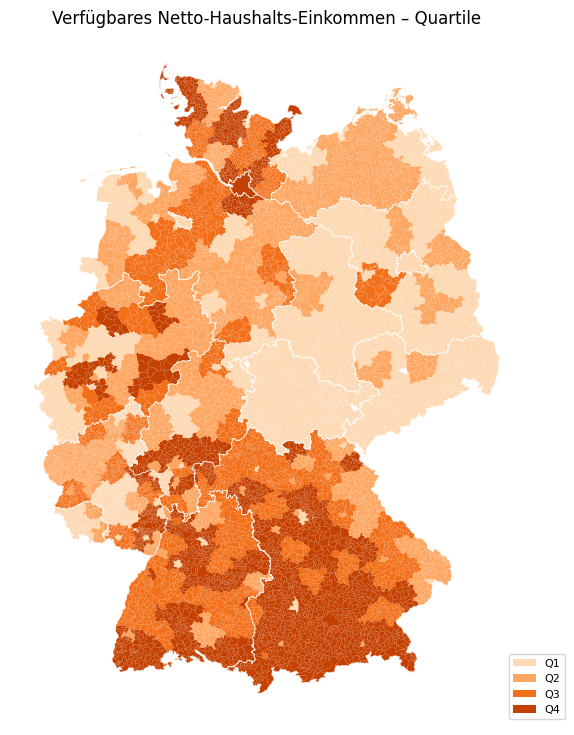

In [20]:
col = "hh_veink_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = cp.colors_from_mpl("Oranges_r", len(labels), clip = 0.8) 
# colors = ['#2F7F64', '#F2C14E', '#B45309']
# colors = ['#009E73', '#E69F00', '#D55E00']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Verfügbares Netto-Haushalts-Einkommen – Quartile",
    # legend_offset_cm=1.0
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Haushaltseinkommen_index_Qs.png", 
    out_dir="exports/Zusatzkarten",
    dpi=300
)


In [21]:
df = pd.read_csv('csv/AltbauAnteil.csv', dtype = {'AGS':str})
df.columns

Index(['AGS', 'GEN', 'ZEITRAUM', 'ANTEIL'], dtype='object')

In [22]:
want = list(df['ZEITRAUM'].unique())
want

['2000 - 2009',
 '2016 und später',
 '1980 - 1989',
 '2010 - 2015',
 '1970 - 1979',
 '1919 - 1949',
 'Vor 1919',
 '1960 - 1969',
 '1950 - 1959',
 '1990 - 1999']

In [23]:
altbau = (
    df[df['ZEITRAUM'].isin(want)]
      .groupby(['AGS', 'ZEITRAUM'])['ANTEIL'].sum()
      .unstack('ZEITRAUM')              # Spalten = Jahr-Kategorien
      .dropna(subset=want)          # wie inner-Join: nur AGS mit beiden Jahren
      .reset_index()
)

In [24]:
altbau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10786 entries, 0 to 10785
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGS              10786 non-null  object 
 1   1919 - 1949      10786 non-null  float64
 2   1950 - 1959      10786 non-null  float64
 3   1960 - 1969      10786 non-null  float64
 4   1970 - 1979      10786 non-null  float64
 5   1980 - 1989      10786 non-null  float64
 6   1990 - 1999      10786 non-null  float64
 7   2000 - 2009      10786 non-null  float64
 8   2010 - 2015      10786 non-null  float64
 9   2016 und später  10786 non-null  float64
 10  Vor 1919         10786 non-null  float64
dtypes: float64(10), object(1)
memory usage: 927.1+ KB


In [25]:
altbau['vor 1949'] = (altbau['Vor 1919']+altbau['1919 - 1949']).fillna(0)

altbau['vor 1979'] = (altbau['Vor 1919']+altbau['1919 - 1949']+altbau['1950 - 1959']+altbau['1960 - 1969'] +altbau['1970 - 1979']).fillna(0)

In [26]:
gdf = gemeinden.merge(
    altbau,
    left_on = 'ARS',
    right_on = 'AGS',
    how = 'inner',
)

In [27]:
gdf.shape

(10737, 40)

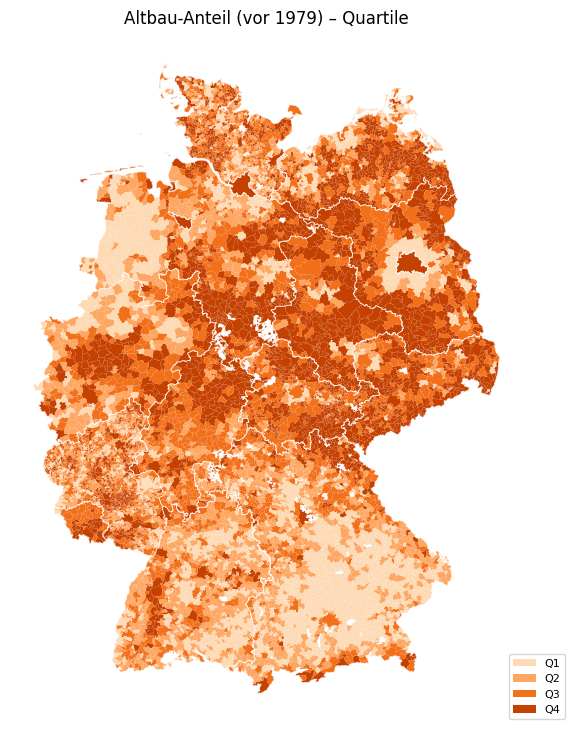

In [28]:
col = "vor 1979"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

colors = cp.colors_from_mpl("Oranges_r", len(labels), clip = 0.8) 
# colors = ['#2F7F64', '#F2C14E', '#B45309']
# colors = ['#009E73', '#E69F00', '#D55E00']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Altbau-Anteil (vor 1979) – Quartile",
    # legend_offset_cm=1.0
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Altbau_Anteil_(vor 1979)_Qs.png", 
    out_dir="exports/Zusatzkarten",
    dpi=300
)

In [29]:
gdf.columns

Index(['OBJID', 'BEGINN', 'ADE', 'GF', 'BSG', 'ARS', 'AGS_x', 'SDV_ARS', 'GEN',
       'BEZ', 'IBZ', 'BEM', 'NBD', 'SN_L', 'SN_R', 'SN_K', 'SN_V1', 'SN_V2',
       'SN_G', 'FK_S3', 'NUTS', 'ARS_0', 'AGS_0', 'WSK', 'DLM_ID', 'geometry',
       'AGS8', 'AGS_y', '1919 - 1949', '1950 - 1959', '1960 - 1969',
       '1970 - 1979', '1980 - 1989', '1990 - 1999', '2000 - 2009',
       '2010 - 2015', '2016 und später', 'Vor 1919', 'vor 1949', 'vor 1979'],
      dtype='object')

In [30]:
# temp = gdf[['ARS','vor 1949', 'vor 1979']].copy()
# temp.to_csv('csv/Altbau_bereinigt.csv',index = False)